# Hugging Face Library 'Transformer'およびT5Tokenizerのダウンロード

参考(https://qiita.com/takubb/items/fd972f0ac3dba909c293)これを基に改造し、最新のGoogle Colaboratoryで動作するようにした

In [1]:
!pip install transformers
!apt install swig
# Sentencepieceのインストール
!pip install sentencepiece
from transformers import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained("rinna/japanese-roberta-base")
tokenizer.do_lower_case = True  # due to some bug of tokenizer config loading

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
     |████████████████████████████████| 1.3 MB 10.5 MB/s eta 0:00:01


# PyTorchとGPU設定

In [2]:
!pip install torch
import torch
# GPUが使えれば利用する設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# データセットの準備

ライブドアニュースコーパスをダウンロード

    ダウンロードしたファイルは圧縮（tar.gz形式）ファイル
    様々なジャンル（IT,スポーツ,家電,映画など）のWEBメディアごとにフォルダに記事がテキストファイルで保存されている
    
以下、ファイルを読み込んで、必要な部分を抽出

In [3]:
import os
import re
import csv
import glob
import warnings
warnings.filterwarnings('ignore')
#urllib.request.urlretrieve("https://www.rondhuit.com/download/ldcc-20140209.tar.gz", "ldcc-20140209.tar.gz")
# ダウンロードした圧縮ファイルのパスを設定
#tgz_fname = "ldcc-20140209.tar.gz" 
# 2つをニュースメディアのジャンルを選定
mydata = '/export/livedoor' 
#処理をした結果を保存するファイル名 
tsv_fname = "all_text.tsv" 

def remove_brackets(inp):
    output = re.sub(u'[〃-〿]', '',(re.sub('＝|=|×|\(|\)|“|”|（|）|／|\[|\]| |　|…|・|\n|\t|/|＜|＞|@|＠', '', re.sub(u'[ℊ-⿻]', '', inp)))) #210A ~ 2FFF
    return output

"""
def read_url(f):
    url = next(f)
    return url[:-1]

def read_date(f):
    date = next(f)
    date = remove_brackets(date.encode().decode('utf-8'))
    return date[:-1]
"""

def read_title(f):
    next(f)
    next(f)
    title = next(f)
    title = remove_brackets(title.encode().decode('utf-8'))
    return title[:-1]

def read_para(f):
    p = ''
    while True:
        try:
            para = next(f)
            para = remove_brackets(para.encode().decode('utf-8'))
            p += para
        except StopIteration:
            break
    return p [:-1]

In [4]:
directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/it-life-hack']
target_genre = ["dokujo-tsushin", "it-life-hack"] 
#directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/peachy']
#target_genre = ["dokujo-tsushin", "peachy"] 
zero_fnames = []
one_fnames = []

if os.path.exists(tsv_fname) == True:
    with open(tsv_fname, "r+") as f:
        f.truncate(0)

for i in range(2):
    for filename in os.listdir(directory[i]):
        if "LICENSE.txt" in filename:
            continue
        f = os.path.join(directory[i], filename)
        #if os.path.isfile(f):
        #    print(f)
        if target_genre[0] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[0], '0', title, para]
                    writer.writerow(row)
            continue
        if target_genre[1] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[1], '1', title, para]
                    writer.writerow(row)
            continue

pandasでデータを読み込み

In [5]:
import pandas as pd
# データの読み込み
df = pd.read_csv("all_text.tsv", 
                 delimiter='\t', header=None, names=['media_name', 'label','title','sentence'])
# データの確認
print(f'データサイズ： {df.shape}')
df.sample(10)

データサイズ： (1740, 4)


,media_name,label,title,sentence
58,dokujo-tsushin,0,子供が欲しくないという女性に共感できますか,女性にとって子供を産むということは、人生における重要な選択なのは間違いない。それはどんな国の...
1432,it-life-hack,1,これなら作ってみたくなる！質感の高いHTPC向けケースが登場,HTPCHomeTheaterPCとは、いわゆるBDタイトルや地デジ放送の録画、ストリーミン...
1279,it-life-hack,1,なつき度アップで要求が次！スマートペット育成記3デジ,ペットロボットスマートペットの育成記第三弾。いよいよ、iPhoneをスマートペット本体に取り...
1165,it-life-hack,1,アノなめこがiPhoneカバーになった！おさわり探偵なめこ栽培キットのiPhoneカバー登場,株式会社ラナからBeeWorksが企画開発配信を行っているiOSAndroid向けアプリシリ...
1595,it-life-hack,1,LAWSONWi-Fiが大炎上！WiFiサービスを使うと友達を無くす規約にTwitterが騒,4月6日にサービスが開始されたLAWSONローソンのWiFiサービスLAWSONWiFi。こ...
553,dokujo-tsushin,0,地方出身者に聞く。今さら田舎に帰れるか,田舎に旅行に出かけいいなあと感じる人は多いだろう。しかし、たとえそれが自分の生まれ育った場所...
1259,it-life-hack,1,女子部必見！Peachyアプリが10万ダウンロードを突,女の子のカワイイとハッピーを応援する総合ニュースアプリPeachyピーチィのダウンロード数が...
1585,it-life-hack,1,この谷間写真は誰得？Twitterのハッシュタグ#女子谷間晒し祭で大いに盛り上が,Twitter上では、気になったツイートをまとめることができるハッシュタグを使い、ときどきイ...
1234,it-life-hack,1,nasneが再出発！出荷延期中だったSCEのnasneの再出荷が決定され,以前、いったい何が起きた？SCEのネットワークレコーダーnasneが突然の出荷延期で紹介した...
858,dokujo-tsushin,0,恋愛に味方する！冬の星座の,節電モードの冬。各地のクリスマスイルミネーションも縮小気味らしい。そんな冬だからこそ、今年は...


//文章データをsentences、ラベルデータを labelsに保存、以降この2変数だけを利用

In [6]:
mn = df.media_name.values
labels = df.label.values
titles = df.title.values
sentences = df.sentence.values

# Moji suu shitei

In [7]:
wcount = 128


# wcount moji me kara kesu

for i in enumerate(sentences):
    if len(i[1])>wcount:
        sentences[i[0]] = sentences[i[0]][:wcount]

'''
# ushiro kara wcount moji toru

for i in enumerate(sentences):
    if len(i[1])>wcount:
        sentences[i[0]] = sentences[i[0]][-wcount:]
#'''

'\n# ushiro kara wcount moji toru\n\nfor i in enumerate(sentences):\n    if len(i[1])>wcount:\n        sentences[i[0]] = sentences[i[0]][-wcount:]\n#'

# BERT Tokenizerを用いて単語分割・IDへ変換
## Tokenizerの準備
単語分割とIDへ変換

# テスト実行

In [8]:
# 元文章
print(' Original: ', sentences[0])
# Tokenizer
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
# Token-id
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  両親や親族が高齢なってくると、自分の人生を見つめ直さないといけないことがある。自分が独女の場合はなお更である。今回の相談者ミミさん女性38歳は母親が介護が必要になったことを機に働き方を変えたのだが、以降、仕事や人間関係がうまく築けずに悩み続けている。同時に
Tokenized:  ['▁', '両親', 'や', '親族', 'が', '高齢', 'な', 'ってくる', 'と', '、', '自分の', '人生', 'を見', 'つめ', '直', 'さない', 'と', 'いけない', 'ことがある', '。', '自分が', '独', '女', 'の場合は', 'なお', '更', 'である', '。', '今回の', '相談', '者', 'ミ', 'ミ', 'さん', '女性', '38', '歳', 'は', '母親', 'が', '介護', 'が必要', 'になった', 'こと', 'を機に', '働き', '方', 'を変えた', 'のだが', '、', '以降', '、', '仕事', 'や', '人間関係', 'が', 'うまく', '築', 'け', 'ずに', '悩み', '続けている', '。', '同時に']
Token IDs:  [9, 3652, 26, 13508, 12, 19860, 57, 9123, 20, 7, 1393, 4221, 1429, 15133, 442, 4569, 20, 19133, 1272, 8, 5144, 2596, 612, 2855, 3244, 13426, 27, 8, 16058, 5448, 147, 318, 318, 774, 577, 1300, 559, 11, 4180, 12, 12079, 3413, 344, 229, 6741, 4294, 478, 20977, 10338, 7, 945, 7, 2416, 26, 27138, 12, 8988, 6671, 1068, 5176, 15710, 9146, 8, 2063]


In [9]:
# 最大単語数の確認
max_len = []
# 1文づつ処理
for sent in sentences:
    # Tokenizeで分割
    token_words = tokenizer.tokenize(sent)
    # 文章数を取得してリストへ格納
    max_len.append(len(token_words))
# 最大の値を確認
print('最大単語数: ', max(max_len))
print('上記の最大単語数にSpecial token（[CLS], [SEP]）の+2をした値が最大単語数')

最大単語数:  91
上記の最大単語数にSpecial token（[CLS], [SEP]）の+2をした値が最大単語数


In [10]:
input_ids = []
attention_masks = []

# 1文づつ処理
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, # Special Tokenの追加
                        max_length = wcount+2,  # I think maximum 文章の長さを固定（Padding/Trancatinating）
                        truncation=True,                
                        pad_to_max_length = True,# PADDINGで埋める
                        return_attention_mask = True,   # Attention maksの作成
                        return_tensors = 'pt',     #  Pytorch tensorsで返す
                   )
    
    # https://qiita.com/YuiKasuga/items/343309257da1798c1b63

    # 単語IDを取得    
    input_ids.append(encoded_dict['input_ids'])

    # Attention　maskの取得
    attention_masks.append(encoded_dict['attention_mask'])

# リストに入ったtensorを縦方向（dim=0）へ結合
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# tenosor型に変換
labels = torch.tensor(labels)

# 確認
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  両親や親族が高齢なってくると、自分の人生を見つめ直さないといけないことがある。自分が独女の場合はなお更である。今回の相談者ミミさん女性38歳は母親が介護が必要になったことを機に働き方を変えたのだが、以降、仕事や人間関係がうまく築けずに悩み続けている。同時に
Token IDs: tensor([    9,  3652,    26, 13508,    12, 19860,    57,  9123,    20,     7,
         1393,  4221,  1429, 15133,   442,  4569,    20, 19133,  1272,     8,
         5144,  2596,   612,  2855,  3244, 13426,    27,     8, 16058,  5448,
          147,   318,   318,   774,   577,  1300,   559,    11,  4180,    12,
        12079,  3413,   344,   229,  6741,  4294,   478, 20977, 10338,     7,
          945,     7,  2416,    26, 27138,    12,  8988,  6671,  1068,  5176,
        15710,  9146,     8,  2063,     2,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3

In [11]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# データセットクラスの作成
dataset = TensorDataset(input_ids, attention_masks, labels)


# 80%地点のIDを取得
#train_size = int(0.1 * len(dataset))
#val_size = len(dataset) - train_size

train_size = 50
val_size = len(dataset) - train_size

# データセットを分割
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('訓練データ数：{}'.format(train_size))
print('検証データ数:　{} '.format(val_size))

# データローダーの作成
batch_size = 32

# 訓練データローダー
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # ランダムにデータを取得してバッチ化
            batch_size = batch_size
        )

# 検証データローダー
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # 順番にデータを取得してバッチ化
            batch_size = batch_size
        )

len(validation_dataloader)

訓練データ数：50
検証データ数:　1690 


53

In [12]:
from transformers import BertForSequenceClassification,AdamW,BertConfig

# BertForSequenceClassification 学習済みモデルのロード
model = BertForSequenceClassification.from_pretrained(
    "cl-tohoku/bert-base-japanese-whole-word-masking", # 日本語Pre trainedモデルの指定
    num_labels = 2, # ラベル数（今回はBinayなので2、数値を増やせばマルチラベルも対応可）
    output_attentions = False, # アテンションベクトルを出力するか
    output_hidden_states = False, # 隠れ層を出力するか
)

# モデルをGPUへ転送
model.cuda()

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [13]:
# 最適化手法の設定
optimizer = AdamW(model.parameters(), lr=2e-5)

# 訓練パートの定義
def train(model):
    model.train() # 訓練モードで実行
    train_loss = 0
    for batch in train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    return train_loss

# テストパートの定義
def validation(model):
    model.eval()# 訓練モードをオフ
    val_loss = 0
    with torch.no_grad(): # 勾配を計算しない
        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            with torch.no_grad():        
                (loss, logits) = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
            val_loss += loss.item()
    return val_loss

In [14]:
# 学習の実行
max_epoch = 50
train_loss_ = []
test_loss_ = []

for epoch in range(max_epoch):
    train_ = train(model)
    test_ = train(model)
    train_loss_.append(train_)
    test_loss_.append(test_)

In [15]:
import statistics

#correct = 0
test_accuracy = []

# 検証方法の確認（1バッチ分で計算ロジックに確認）

model.eval()# 訓練モードをオフ
for batch in validation_dataloader:
    #print(batch)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    #print(len(b_labels))
    with torch.no_grad():   
        # 学習済みモデルによる予測結果をpredsで取得     
        preds = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        
        test_accuracy.append((torch.argmax(preds[0], 1) == b_labels).sum().item() / len(b_labels))

        #print('preds: ', torch.argmax(preds[0], 1))
        #print('b_labels: ', b_labels)
'''
        if preds == b_labels:
            correct += 1
            #test_accuracy += torch.sum(preds == b_labels).item() / len(b_labels)

#test_accuracy = correct/len(b_labels)
print(correct)
'''
print(statistics.mean(test_accuracy))


0.6625090711175616


In [16]:
a = torch.randn(4, 4)
print(a)
print(torch.argmax(a))

tensor([[ 0.7689, -0.0197, -1.4855, -0.3250],
        [-1.7694,  0.4121, -0.3210, -0.1933],
        [-0.1223,  0.2940,  0.0518, -1.7902],
        [ 0.9650,  0.7839, -0.2714, -0.2395]])
tensor(12)


In [17]:
# 予測結果の確認
print(f'出力:{preds}')

出力:SequenceClassifierOutput(loss=None, logits=tensor([[-0.7903,  0.7840],
        [ 4.8271, -3.7320],
        [ 3.0750, -2.5008],
        [ 4.1859, -3.1749],
        [ 5.0497, -3.8913],
        [ 3.3562, -2.8362],
        [ 4.9224, -3.8544],
        [ 4.8671, -3.8124],
        [ 5.0018, -3.8877],
        [ 4.9749, -3.9069],
        [-1.8553,  1.5531],
        [ 5.0447, -3.8577],
        [ 4.9495, -3.8276],
        [-2.9404,  2.3401],
        [ 4.8738, -3.8419],
        [ 3.6612, -2.9746],
        [-2.6923,  2.0390],
        [ 4.6998, -3.7022],
        [ 4.9564, -3.8539],
        [ 4.7228, -3.6198],
        [-4.4710,  3.4206],
        [ 4.9825, -3.8607],
        [ 2.3514, -2.0221],
        [ 4.9382, -3.8729],
        [-3.9312,  3.3055],
        [ 4.9649, -3.8763]], device='cuda:0'), hidden_states=None, attentions=None)


In [18]:
# 比較しやすい様にpd.dataframeへ整形
import numpy as np
# pd.dataframeへ変換（GPUに乗っているTensorはgpu->cpu->numpy->dataframeと変換）
logits_df = pd.DataFrame(preds[0].cpu().numpy(), columns=['logit_0', 'logit_1'])
## np.argmaxで大き方の値を取得
pred_df = pd.DataFrame(np.argmax(preds[0].cpu().numpy(), axis=1), columns=['pred_label'])
label_df = pd.DataFrame(b_labels.cpu().numpy(), columns=['true_label'])
accuracy_df = pd.concat([logits_df, pred_df, label_df], axis=1)
accuracy_df.head()

,logit_0,logit_1,pred_label,true_label
0,-0.790280,0.783962,1,1
1,4.827054,-3.732003,0,1
2,3.074958,-2.500754,0,1
3,4.185898,-3.174947,0,0
4,5.049746,-3.891285,0,0


In [19]:
'''
correct = 0
test_accuracy = 0

p_list = []
l_list = []

p_list = pred_df.values.tolist()
l_list = label_df.values.tolist()

#print(type(pred_df))

for i in range(len(b_labels)):
    if(p_list[i] == l_list[i]):
        correct += 1

test_accuracy = correct/len(b_labels)

print(test_accuracy)
'''

'\ncorrect = 0\ntest_accuracy = 0\n\np_list = []\nl_list = []\n\np_list = pred_df.values.tolist()\nl_list = label_df.values.tolist()\n\n#print(type(pred_df))\n\nfor i in range(len(b_labels)):\n    if(p_list[i] == l_list[i]):\n        correct += 1\n\ntest_accuracy = correct/len(b_labels)\n\nprint(test_accuracy)\n'

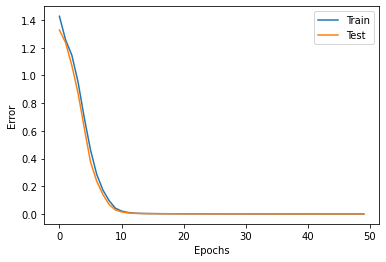

In [20]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_)), train_loss_, label="Train")
plt.plot(range(len(test_loss_)), test_loss_, label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()  # ラベルがあるときは、きちんとplt.show()を呼び出すこと